# Statistical Inference on Price of Airbnb Listings Given Property Type and Cancellation Policy
Group 39
## Introduction
### Background
Home-sharing platforms such as Airbnb have been growing since the last decade, the user count still climbing steadily to this day. The effects of such services on the hospitality sector is also increasing as these platforms scale up. The fact that Airbnb alone provides more listings than the top five hotel companies worldwide provide in total (Hartmans, 2017) presents a glimpse to the sheer market-dominant power of the home-sharing boom. Thus, as Airbnb becomes more common, home owners are finding Airbnb to be an increasingly lucrative way to use their property, which makes knowing favorable kinds of property valuable for decision making among many parties, including real estate brokers, homebuyers, and property owners. For our analysis we will focus our statistical inference on one variable: the price of a listing to check if apartments are listed as more expensive than houses in the Airbnb market. 

## Methods and Results

We define notations as follows:

- $\mu_h =$  population mean log price of house type listings

- $\mu_a =$ population mean log price of apartment type listings

- $x_h =$  sample mean log price of house type listings

- $x_a =$ sample mean log price of apartment type listings

Through a preliminary examination, we observe that the point estimate, $d$, the difference in sample means, is greater than 0. $d = x_h - x_a = 0.0383 > 0$. We’d like to check if this is statistically significant using inference. In other words, we check if there is evidence to reject our null hypothesis $H_0: \mu_h - \mu_a = 0$. We set our alternative hypothesis as $H_1: \mu_h - \mu_a >0$ since we are interested in whether or not the difference in population means $\mu_h - \mu_a$ is greater than 0.

Our data is obtained from Kaggle and includes various characteristics of Airbnb listings, two of which we focus on in this project: natural log of price in US Dollars and house type



Our point estimate is $d = 0.0383$, and this estimate is not sufficient for stakeholders because it was derived from a random sample, and we cannot directly extrapolate the results of one sample to the entire population. Therefore, we will construct a confidence interval via theoretical methods to quantify the errors associated with our point estimate. To establish statistical significance, a hypothesis test (two-sample t-test) will be conducted with a significance level of 0.05. We will account for variance as part of the investigation of a scale parameter. Verification of conditions required for two sample t-test will be conducted in a later deliverable.  As a result of this project, we expect to find that $\mu_h - \mu_a > 0$, as our point estimate indicates.

In [2]:
# load packages
library(tidyverse)
library(tidymodels)
library(cowplot)
library(datateachr)
library(digest)
library(infer)
library(repr)
library(taxyvr)
library(tidyverse)
library(broom)
library(digest)
library(grid)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.1     ✔ rsample      1.1.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.3     ✔ workflows    1.0.0
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.1     ✔ yardstick    1.1.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() ma

In [3]:
# read data
set.seed(320)
Airbnb <- read.csv("https://raw.githubusercontent.com/takumihoriba/stat201-project/stat201/data/train.csv") 


In [4]:
print("Table 1: Raw data set") 
head(Airbnb)

[1] "Table 1: Raw data set"


,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,⋯,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds
,<int>,<dbl>,<chr>,<chr>,<chr>,<int>,<dbl>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<chr>,<chr>,<int>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
1,6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitchen,Heating,""Family/kid friendly"",Essentials,""Hair dryer"",Iron,""translation missing: en.hosting_amenity_50""}",3,1,Real Bed,strict,True,⋯,40.69652,-73.99162,Beautiful brownstone 1-bedroom,Brooklyn Heights,2,100,https://a0.muscache.com/im/pictures/6d7cbbf7-c034-459c-bc82-6522c957627c.jpg?aki_policy=small,11201,1,1
2,6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitchen,Heating,""Family/kid friendly"",Washer,Dryer,""Smoke detector"",""Fire extinguisher"",Essentials,Shampoo,Hangers,""Hair dryer"",Iron,""translation missing: en.hosting_amenity_50""}",7,1,Real Bed,strict,True,⋯,40.76612,-73.98904,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,93,https://a0.muscache.com/im/pictures/348a55fe-4b65-452a-b48a-bfecb3b58a66.jpg?aki_policy=small,10019,3,3
3,7919400,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air conditioning"",Kitchen,Breakfast,""Buzzer/wireless intercom"",Heating,""Family/kid friendly"",""Smoke detector"",""Carbon monoxide detector"",""Fire extinguisher"",Essentials,Shampoo,Hangers,""Hair dryer"",Iron,""Laptop friendly workspace"",""translation missing: en.hosting_amenity_50""}",5,1,Real Bed,moderate,True,⋯,40.80811,-73.94376,The Garden Oasis,Harlem,10,92,https://a0.muscache.com/im/pictures/6fae5362-9e3a-4fa9-aa54-bbd5ea26538d.jpg?aki_policy=small,10027,1,3
4,13418779,6.620073,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Kitchen,""Indoor fireplace"",""Buzzer/wireless intercom"",Heating,Washer,Dryer,""Smoke detector"",""Carbon monoxide detector"",""First aid kit"",""Fire extinguisher"",Essentials}",4,1,Real Bed,flexible,True,⋯,37.77200,-122.43162,Beautiful Flat in the Heart of SF!,Lower Haight,0,NA,https://a0.muscache.com/im/pictures/72208dad-9c86-41ea-a735-43d933111063.jpg?aki_policy=small,94117.0,2,2
5,3808709,4.744932,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditioning"",Kitchen,""Elevator in building"",Heating,""Smoke detector"",""Carbon monoxide detector"",""Fire extinguisher"",Essentials,Shampoo}",2,1,Real Bed,moderate,True,⋯,38.92563,-77.03460,Great studio in midtown DC,Columbia Heights,4,40,,20009,0,1
6,12422935,4.442651,Apartment,Private room,"{TV,""Wireless Internet"",Heating,""Smoke detector"",""Carbon monoxide detector"",""First aid kit"",""Fire extinguisher"",Essentials,Hangers,""Laptop friendly workspace""}",2,1,Real Bed,strict,True,⋯,37.75316,-122.42953,Comfort Suite San Francisco,Noe Valley,3,100,https://a0.muscache.com/im/pictures/82509143-4b21-44eb-a556-e3c1e0afac60.jpg?aki_policy=small,94131,1,1


In [5]:
#Clean and wrangle the dataset into a tidy format
set.seed(320)
#choose needed column
Airbnb_tidy <- Airbnb |> select(log_price, property_type) |> filter(property_type %in% c("House", "Apartment")) 

#Check the size of the dataset to ensure that the dataset is a sample and not a population
nrow(Airbnb_tidy)
print("Table 2: Tidy form dataset") 
head(Airbnb_tidy)

[1] 65514

[1] "Table 2: Tidy form dataset"


,log_price,property_type
,<dbl>,<chr>
1,5.010635,Apartment
2,5.129899,Apartment
3,4.976734,Apartment
4,6.620073,House
5,4.744932,Apartment
6,4.442651,Apartment


### Inference on mean log price given the two property types, house and apartment

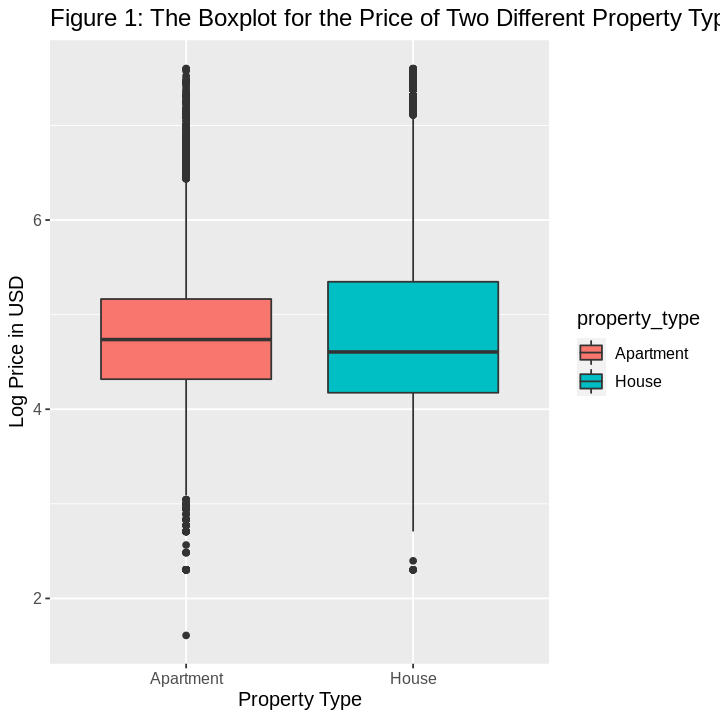

In [7]:
#creat boxplot for the Log Price for two different property types (House and Apartment)
#(explanatory variable is property type and response variable is the log price)
set.seed(320)
options(repr.plot.width = 6, repr.plot.height = 6)
log_price_boxplot <- ggplot(Airbnb_tidy,aes(x=property_type,y=log_price, fill = property_type))+
                     geom_boxplot()+
                     labs(x="Property Type",y="Log Price in USD") +
                     theme(text=element_text(size=12))+
                     labs(title="Figure 1: The Boxplot for the Price of Two Different Property Type in Aribnb")
log_price_boxplot



In [14]:
#Preliminary exploratory data analysis
#Calculate the percentage of each type of property (House and Apartment) in the dataset
set.seed(320)
prop_house_apartment <- Airbnb_tidy |>
group_by(property_type) |>
summarize(percent =  n()/nrow(Airbnb_tidy )) |>
arrange(desc(percent))
print("Table 3: the proportion of the property type") 
prop_house_apartment

[1] "Table 3: the proportion of the property type"


property_type,percent
<chr>,<dbl>
Apartment,0.7479775
House,0.2520225


In [16]:
#estimate the parameter
#calculate the mean, sd, min and max value for each property type 
set.seed(320)
Airbnb_summary <- Airbnb_tidy |> group_by(property_type)|> summarize(mean = mean(log_price),sd=sd(log_price),min=min(log_price),
                                                                    max=max(log_price),n=n())
print("Table 4: Data Summary") 
Airbnb_summary

[1] "Table 4: Data Summary"


property_type,mean,sd,min,max,n
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
Apartment,4.758850,0.6408249,1.609438,7.600402,49003
House,4.797114,0.8758650,2.302585,7.600402,16511


### Two-sample T-test

- significance level = 5%

In [22]:
# Execute two-sample t-test
set.seed(320)
apartment <- Airbnb_tidy |>
             filter(property_type=="Apartment")|>
             select(log_price)
house <- Airbnb_tidy |>
             filter(property_type=="House")|>
             select(log_price)
two_sample_t_test <- tidy(
                          t.test(x = house,
                                 y = apartment,
                                 alternative = "greater"))
print("Table 5: Results of the t-test") 
two_sample_t_test

[1] "Table 5: Results of the t-test"


estimate,estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
0.03826355,4.797114,4.75885,5.166856,1.200363e-07,22753.4,0.02608197,Inf,Welch Two Sample t-test,greater


### Bootstrapping

Bootstrap 95% Confidence Interval

In [32]:
set.seed(320) 
# get the p value by bootstrapping
sample <-  Airbnb_tidy %>%
           rep_sample_n(size = 10000,reps=1,replace=FALSE) |>
           ungroup() |>
           select(-replicate)

# obs_mean_diff <- sample |> group_by(property_type) |> summarise(mean = mean(log_price)) |> 
#                  pivot_wider(names_from = property_type,values_from = mean) |>
#                  transmute(diff = House-Apartment) |>
#                  pull(diff)

bootstrapping  <- sample |>
              specify(formula = log_price ~ property_type)  %>%
              hypothesize(null = "independence") %>%
              generate(reps = 1000, type = "bootstrap") %>%
              calculate(stat = "diff in means", order = c("House", "Apartment")) |>
              get_ci(level = 0.95)
              # get_p_value(obs_stat = obs_mean_diff, direction = "right")

print("Table 6: Confidence Interval (Bootstrapping)") 
bootstrapping
# get_p_value(obs_stat = observed_mean, direction = "right")

[1] "Table 6: Confidence Interval (Bootstrapping)"


lower_ci,upper_ci
<dbl>,<dbl>
0.005772328,0.07913184


### Inference on Mean Log Price given different cancellation policies through Analysis of Variance
Secondly, we perform analysis of variance on price based on different cancellation policy.
Our null hypothesis is that all the mean log prices are the same, and the alternative hypothesis is that at least one of the mean log prices is different from each other.

anova multivariable. why box plots??

For error analysis, explain what's type 1 and 2 in our contexts (for both tests)

The variable `cancellation_policy` represents a level of flexibility for cancellation for a listing, and we will utilize this categorical variable to divide the sample into five different groups to conduct a hypothesis test. 

By the figure 2 below, we can suppose that some groups have largely different means than the other groups. We would like to check if this is true with statistical significance. To do so, we employ ANOVA with significance level of 0.05 as follows.

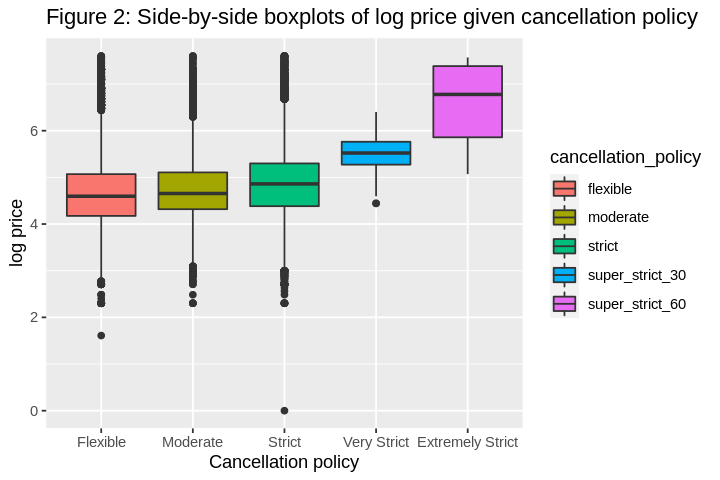

In [25]:
# Comparison of mean log prices given cancellation policy
options(repr.plot.width = 6, repr.plot.height = 4)
bp <- Airbnb |>
    ggplot(aes(x = cancellation_policy, y = log_price, fill = cancellation_policy)) +
    geom_boxplot() +
    scale_x_discrete(labels = c("Flexible", "Moderate", "Strict", "Very Strict", "Extremely Strict"))+
    labs(title = "Figure 2: Side-by-side boxplots of log price given cancellation policy", x = "Cancellation policy", y = "log price")
bp

In [27]:
# ANOVA
anova_results <- 
    aov(log_price ~ property_type, data = Airbnb) %>% 
    tidy()
print("Table 7: Result of ANOVA") 
anova_results

[1] "Table 7: Result of ANOVA"


term,df,sumsq,meansq,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
property_type,34,663.7679,19.5225848,38.58757,1.742985e-251
Residuals,74076,37477.2283,0.5059294,NA,NA


As a result, since p-value is smaller than 0.05, we reject the null hypothesis and we conclude that at least one mean log price is different from the others. 

## Discussion

Our findings could help people, including both renters and lessors, to make informed decisions about housing. The results will lead to more questions, such as why such a result was produced or if it changes depending on location or seasonality.

- Discuss result of the first test
- Discuss result of the second test

## References
Airbnb price prediction. www.kaggle.com. [accessed 2023 Mar 18]. https://www.kaggle.com/datasets/stevezhenghp/airbnb-price-prediction?resource=download.

Barron K, Kung E, Proserpio D. 2020. The Effect of Home-Sharing on House Prices and Rents: Evidence from Airbnb. Marketing Science. 40(1). doi:https://doi.org/10.1287/mksc.2020.1227.

Cheng M, Foley C. 2018. The sharing economy and digital discrimination: The case of Airbnb. International Journal of Hospitality Management. 70:95–98. doi:https://doi.org/10.1016/j.ijhm.2017.11.002.

Garcia-López M-À, Jofre-Monseny J, Martínez-Mazza R, Segú M. 2020. Do short-term rental platforms affect housing markets? Evidence from Airbnb in Barcelona. Journal of Urban Economics. 119:103278. doi:https://doi.org/10.1016/j.jue.2020.103278. https://www.sciencedirect.com/science/article/pii/S0094119020300498.

Guttentag DA, Smith SLJ. 2017. Assessing Airbnb as a disruptive innovation relative to hotels: Substitution and comparative performance expectations. International Journal of Hospitality Management. 64:1–10. doi:https://doi.org/10.1016/j.ijhm.2017.02.003. https://www.sciencedirect.com/science/article/pii/S0278431916302250.

Horn K, Merante M. 2017. Is home sharing driving up rents? Evidence from Airbnb in Boston. Journal of Housing Economics. 38:14–24. doi:https://doi.org/10.1016/j.jhe.2017.08.002.

Kwok L, Xie KL. 2018 Oct. Pricing strategies on Airbnb: Are multi-unit hosts revenue pros? International Journal of Hospitality Management. doi:https://doi.org/10.1016/j.ijhm.2018.09.013.

Mody MA, Suess C, Lehto X. 2017. The accommodation experiencescape: a comparative assessment of hotels and Airbnb. International Journal of Contemporary Hospitality Management. 29(9):2377–2404. doi:https://doi.org/10.1108/ijchm-09-2016-0501.

Wachsmuth D, Weisler A. 2018. Airbnb and the rent gap: Gentrification through the sharing economy. Environment and Planning A: Economy and Space. 50(6):1147–1170. doi:https://doi.org/10.1177/0308518x18778038.

ZERVAS G, PROSERPIO D, BYERS JW. 2017. The Rise of the Sharing Economy: Estimating the Impact of Airbnb on the Hotel Industry. Journal of Marketing Research. 54(5):687–705. https://www.jstor.org/stable/44878526.